<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:44:44] /work/mxnet/src/storage/storage.cc:205: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


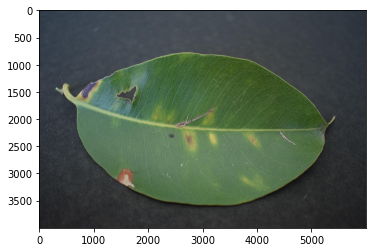

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

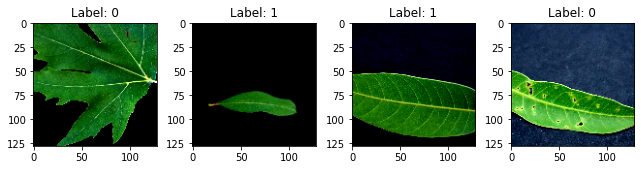

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:44:50] /work/mxnet/src/storage/storage.cc:205: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:44:51] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:107: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.1880782972961776 samples/sec                   batch loss = 1.272830843925476 | accuracy = 0.25


Epoch[1] Batch[10] Speed: 1.2614677650525672 samples/sec                   batch loss = 0.4637583792209625 | accuracy = 0.475


Epoch[1] Batch[15] Speed: 1.2699460985709827 samples/sec                   batch loss = 0.41346171498298645 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.260966877140777 samples/sec                   batch loss = 1.2448127269744873 | accuracy = 0.5375


Epoch[1] Batch[25] Speed: 1.2706395611491488 samples/sec                   batch loss = 0.9430968165397644 | accuracy = 0.56


Epoch[1] Batch[30] Speed: 1.2710949072230855 samples/sec                   batch loss = 1.9857773780822754 | accuracy = 0.5833333333333334


Epoch[1] Batch[35] Speed: 1.2615923139885903 samples/sec                   batch loss = 0.6482651829719543 | accuracy = 0.5928571428571429


Epoch[1] Batch[40] Speed: 1.2645487562930784 samples/sec                   batch loss = 0.6606670022010803 | accuracy = 0.59375


Epoch[1] Batch[45] Speed: 1.2595446988843297 samples/sec                   batch loss = 0.39193078875541687 | accuracy = 0.6055555555555555


Epoch[1] Batch[50] Speed: 1.262686707129019 samples/sec                   batch loss = 0.4096178710460663 | accuracy = 0.595


Epoch[1] Batch[55] Speed: 1.2634224957096376 samples/sec                   batch loss = 0.6358027458190918 | accuracy = 0.6


Epoch[1] Batch[60] Speed: 1.2582297983858388 samples/sec                   batch loss = 0.5498083829879761 | accuracy = 0.6041666666666666


Epoch[1] Batch[65] Speed: 1.2701967541769001 samples/sec                   batch loss = 0.5332143306732178 | accuracy = 0.5961538461538461


Epoch[1] Batch[70] Speed: 1.2662901331704646 samples/sec                   batch loss = 0.6138466596603394 | accuracy = 0.6035714285714285


Epoch[1] Batch[75] Speed: 1.2689424491295032 samples/sec                   batch loss = 0.6823230385780334 | accuracy = 0.61


Epoch[1] Batch[80] Speed: 1.2617002826211352 samples/sec                   batch loss = 0.4124031066894531 | accuracy = 0.621875


Epoch[1] Batch[85] Speed: 1.2576998923955902 samples/sec                   batch loss = 1.2011430263519287 | accuracy = 0.6147058823529412


Epoch[1] Batch[90] Speed: 1.2582607500898477 samples/sec                   batch loss = 0.4734089970588684 | accuracy = 0.6194444444444445


Epoch[1] Batch[95] Speed: 1.2622559775819844 samples/sec                   batch loss = 0.8349901437759399 | accuracy = 0.6157894736842106


Epoch[1] Batch[100] Speed: 1.260269255610143 samples/sec                   batch loss = 0.866743803024292 | accuracy = 0.605


Epoch[1] Batch[105] Speed: 1.2624829907119863 samples/sec                   batch loss = 0.5812432169914246 | accuracy = 0.6047619047619047


Epoch[1] Batch[110] Speed: 1.2596836227845354 samples/sec                   batch loss = 0.356664776802063 | accuracy = 0.6113636363636363


Epoch[1] Batch[115] Speed: 1.2614931850770217 samples/sec                   batch loss = 0.6341537833213806 | accuracy = 0.6108695652173913


Epoch[1] Batch[120] Speed: 1.2649810522950624 samples/sec                   batch loss = 1.1393879652023315 | accuracy = 0.6104166666666667


Epoch[1] Batch[125] Speed: 1.2695071368658173 samples/sec                   batch loss = 0.6421106457710266 | accuracy = 0.61


Epoch[1] Batch[130] Speed: 1.2655570159399143 samples/sec                   batch loss = 0.7616385817527771 | accuracy = 0.6115384615384616


Epoch[1] Batch[135] Speed: 1.2618442379129033 samples/sec                   batch loss = 0.7135100364685059 | accuracy = 0.6074074074074074


Epoch[1] Batch[140] Speed: 1.2663968044065241 samples/sec                   batch loss = 0.5868461728096008 | accuracy = 0.6107142857142858


Epoch[1] Batch[145] Speed: 1.2613643881953993 samples/sec                   batch loss = 0.3444436490535736 | accuracy = 0.6155172413793103


Epoch[1] Batch[150] Speed: 1.2549282432936217 samples/sec                   batch loss = 0.8202047944068909 | accuracy = 0.6183333333333333


Epoch[1] Batch[155] Speed: 1.2589042863874707 samples/sec                   batch loss = 0.7104542851448059 | accuracy = 0.617741935483871


Epoch[1] Batch[160] Speed: 1.254830252680083 samples/sec                   batch loss = 0.6939834952354431 | accuracy = 0.6171875


Epoch[1] Batch[165] Speed: 1.260416861526543 samples/sec                   batch loss = 0.5127720832824707 | accuracy = 0.6166666666666667


Epoch[1] Batch[170] Speed: 1.2617567410650092 samples/sec                   batch loss = 0.5272306799888611 | accuracy = 0.6205882352941177


Epoch[1] Batch[175] Speed: 1.2596713273980806 samples/sec                   batch loss = 0.4447479844093323 | accuracy = 0.6228571428571429


Epoch[1] Batch[180] Speed: 1.2638830610210283 samples/sec                   batch loss = 0.4134056568145752 | accuracy = 0.6333333333333333


Epoch[1] Batch[185] Speed: 1.2588937065279442 samples/sec                   batch loss = 0.810659646987915 | accuracy = 0.6351351351351351


Epoch[1] Batch[190] Speed: 1.2631729846337139 samples/sec                   batch loss = 0.5399844646453857 | accuracy = 0.6368421052631579


Epoch[1] Batch[195] Speed: 1.2652358582094365 samples/sec                   batch loss = 0.6967850923538208 | accuracy = 0.6371794871794871


Epoch[1] Batch[200] Speed: 1.2620706282551386 samples/sec                   batch loss = 0.3149842619895935 | accuracy = 0.64125


Epoch[1] Batch[205] Speed: 1.268691041070971 samples/sec                   batch loss = 0.20213542878627777 | accuracy = 0.6451219512195122


Epoch[1] Batch[210] Speed: 1.2566775631750051 samples/sec                   batch loss = 0.44250166416168213 | accuracy = 0.6476190476190476


Epoch[1] Batch[215] Speed: 1.2637404488152915 samples/sec                   batch loss = 0.21300676465034485 | accuracy = 0.6511627906976745


Epoch[1] Batch[220] Speed: 1.2629900281005453 samples/sec                   batch loss = 0.5985758304595947 | accuracy = 0.6522727272727272


Epoch[1] Batch[225] Speed: 1.2612318250617227 samples/sec                   batch loss = 0.32979023456573486 | accuracy = 0.6522222222222223


Epoch[1] Batch[230] Speed: 1.256792788797556 samples/sec                   batch loss = 0.5443497896194458 | accuracy = 0.6521739130434783


Epoch[1] Batch[235] Speed: 1.262784978193022 samples/sec                   batch loss = 1.1174861192703247 | accuracy = 0.65


Epoch[1] Batch[240] Speed: 1.268117302023527 samples/sec                   batch loss = 0.5909180045127869 | accuracy = 0.6489583333333333


Epoch[1] Batch[245] Speed: 1.2617497190674498 samples/sec                   batch loss = 0.41329771280288696 | accuracy = 0.6489795918367347


Epoch[1] Batch[250] Speed: 1.261350353011158 samples/sec                   batch loss = 0.6639916896820068 | accuracy = 0.653


Epoch[1] Batch[255] Speed: 1.262050026697013 samples/sec                   batch loss = 0.6432023048400879 | accuracy = 0.6529411764705882


Epoch[1] Batch[260] Speed: 1.267320988777136 samples/sec                   batch loss = 0.4530352056026459 | accuracy = 0.6528846153846154


Epoch[1] Batch[265] Speed: 1.2617244784783876 samples/sec                   batch loss = 0.6748939752578735 | accuracy = 0.6547169811320754


Epoch[1] Batch[270] Speed: 1.2592616499905653 samples/sec                   batch loss = 0.5779470205307007 | accuracy = 0.6574074074074074


Epoch[1] Batch[275] Speed: 1.2614915725823521 samples/sec                   batch loss = 0.6871361136436462 | accuracy = 0.6618181818181819


Epoch[1] Batch[280] Speed: 1.2561289310612944 samples/sec                   batch loss = 0.34855666756629944 | accuracy = 0.6625


Epoch[1] Batch[285] Speed: 1.262098351228941 samples/sec                   batch loss = 0.2883979082107544 | accuracy = 0.6622807017543859


Epoch[1] Batch[290] Speed: 1.259588481666981 samples/sec                   batch loss = 0.581213116645813 | accuracy = 0.6629310344827586


Epoch[1] Batch[295] Speed: 1.2587808342750122 samples/sec                   batch loss = 0.68742436170578 | accuracy = 0.6661016949152543


Epoch[1] Batch[300] Speed: 1.255081266905825 samples/sec                   batch loss = 0.42172130942344666 | accuracy = 0.6666666666666666


Epoch[1] Batch[305] Speed: 1.263391670096137 samples/sec                   batch loss = 0.23103712499141693 | accuracy = 0.6688524590163935


Epoch[1] Batch[310] Speed: 1.2635754091824305 samples/sec                   batch loss = 0.42846763134002686 | accuracy = 0.6685483870967742


Epoch[1] Batch[315] Speed: 1.2637215060907852 samples/sec                   batch loss = 0.6207178831100464 | accuracy = 0.6682539682539682


Epoch[1] Batch[320] Speed: 1.263979042492263 samples/sec                   batch loss = 0.6760818958282471 | accuracy = 0.6703125


Epoch[1] Batch[325] Speed: 1.2634021354135485 samples/sec                   batch loss = 1.0012898445129395 | accuracy = 0.6723076923076923


Epoch[1] Batch[330] Speed: 1.2612112508788786 samples/sec                   batch loss = 0.9949193000793457 | accuracy = 0.6757575757575758


Epoch[1] Batch[335] Speed: 1.2642758393268294 samples/sec                   batch loss = 0.22534380853176117 | accuracy = 0.6761194029850747


Epoch[1] Batch[340] Speed: 1.2597083088620544 samples/sec                   batch loss = 0.5949292182922363 | accuracy = 0.675


Epoch[1] Batch[345] Speed: 1.2649996512756714 samples/sec                   batch loss = 0.5145949721336365 | accuracy = 0.6746376811594202


Epoch[1] Batch[350] Speed: 1.2611731382675837 samples/sec                   batch loss = 2.1552271842956543 | accuracy = 0.6728571428571428


Epoch[1] Batch[355] Speed: 1.2611271597003761 samples/sec                   batch loss = 0.4664117097854614 | accuracy = 0.673943661971831


Epoch[1] Batch[360] Speed: 1.2621810526771933 samples/sec                   batch loss = 0.592942476272583 | accuracy = 0.6743055555555556


Epoch[1] Batch[365] Speed: 1.2718171984737783 samples/sec                   batch loss = 0.5381808876991272 | accuracy = 0.6753424657534246


Epoch[1] Batch[370] Speed: 1.2642077237523541 samples/sec                   batch loss = 0.22046266496181488 | accuracy = 0.677027027027027


Epoch[1] Batch[375] Speed: 1.2666228232724923 samples/sec                   batch loss = 0.6714576482772827 | accuracy = 0.6773333333333333


Epoch[1] Batch[380] Speed: 1.2626610489246446 samples/sec                   batch loss = 0.5022748112678528 | accuracy = 0.6782894736842106


Epoch[1] Batch[385] Speed: 1.2613648623624834 samples/sec                   batch loss = 0.36216649413108826 | accuracy = 0.6798701298701298


Epoch[1] Batch[390] Speed: 1.2670302242139597 samples/sec                   batch loss = 0.931847333908081 | accuracy = 0.6814102564102564


Epoch[1] Batch[395] Speed: 1.2628957177870517 samples/sec                   batch loss = 0.575772762298584 | accuracy = 0.6810126582278481


Epoch[1] Batch[400] Speed: 1.2630548746123442 samples/sec                   batch loss = 0.6268023252487183 | accuracy = 0.680625


Epoch[1] Batch[405] Speed: 1.2691535360982424 samples/sec                   batch loss = 0.4457071125507355 | accuracy = 0.6790123456790124


Epoch[1] Batch[410] Speed: 1.2689549261698143 samples/sec                   batch loss = 0.7006930112838745 | accuracy = 0.6780487804878049


Epoch[1] Batch[415] Speed: 1.2647427476112711 samples/sec                   batch loss = 0.6469812989234924 | accuracy = 0.677710843373494


Epoch[1] Batch[420] Speed: 1.255538776505675 samples/sec                   batch loss = 0.31379255652427673 | accuracy = 0.6773809523809524


Epoch[1] Batch[425] Speed: 1.2613036977517103 samples/sec                   batch loss = 0.4431372284889221 | accuracy = 0.6758823529411765


Epoch[1] Batch[430] Speed: 1.259737725336561 samples/sec                   batch loss = 0.570560097694397 | accuracy = 0.6773255813953488


Epoch[1] Batch[435] Speed: 1.2581595965062053 samples/sec                   batch loss = 0.3601849377155304 | accuracy = 0.6787356321839081


Epoch[1] Batch[440] Speed: 1.264527978442476 samples/sec                   batch loss = 0.6517077088356018 | accuracy = 0.678409090909091


Epoch[1] Batch[445] Speed: 1.2584714131063568 samples/sec                   batch loss = 0.5040141940116882 | accuracy = 0.6786516853932584


Epoch[1] Batch[450] Speed: 1.2652510296010782 samples/sec                   batch loss = 0.3910815417766571 | accuracy = 0.68


Epoch[1] Batch[455] Speed: 1.2686893141845912 samples/sec                   batch loss = 0.9861437082290649 | accuracy = 0.6796703296703297


Epoch[1] Batch[460] Speed: 1.2723100528945648 samples/sec                   batch loss = 0.5257250070571899 | accuracy = 0.6809782608695653


Epoch[1] Batch[465] Speed: 1.262008066156444 samples/sec                   batch loss = 0.5544643402099609 | accuracy = 0.6817204301075269


Epoch[1] Batch[470] Speed: 1.2640903725955788 samples/sec                   batch loss = 0.2966269850730896 | accuracy = 0.6813829787234043


Epoch[1] Batch[475] Speed: 1.2625466450307423 samples/sec                   batch loss = 0.98829585313797 | accuracy = 0.68


Epoch[1] Batch[480] Speed: 1.2688708548571708 samples/sec                   batch loss = 0.4831094741821289 | accuracy = 0.6802083333333333


Epoch[1] Batch[485] Speed: 1.2609380666190917 samples/sec                   batch loss = 0.37992215156555176 | accuracy = 0.6804123711340206


Epoch[1] Batch[490] Speed: 1.2590736828170288 samples/sec                   batch loss = 0.5204972624778748 | accuracy = 0.6816326530612244


Epoch[1] Batch[495] Speed: 1.2628183406101705 samples/sec                   batch loss = 0.3847213089466095 | accuracy = 0.6828282828282828


Epoch[1] Batch[500] Speed: 1.2686904654416555 samples/sec                   batch loss = 0.6411911249160767 | accuracy = 0.6815


Epoch[1] Batch[505] Speed: 1.2662994040612237 samples/sec                   batch loss = 0.8010027408599854 | accuracy = 0.6821782178217822


Epoch[1] Batch[510] Speed: 1.26423249220292 samples/sec                   batch loss = 1.5310564041137695 | accuracy = 0.6843137254901961


Epoch[1] Batch[515] Speed: 1.2619013736398463 samples/sec                   batch loss = 0.2886015474796295 | accuracy = 0.6873786407766991


Epoch[1] Batch[520] Speed: 1.2702392610250912 samples/sec                   batch loss = 0.4168108403682709 | accuracy = 0.6875


Epoch[1] Batch[525] Speed: 1.2674696767242242 samples/sec                   batch loss = 0.6335117816925049 | accuracy = 0.6876190476190476


Epoch[1] Batch[530] Speed: 1.2737858817568073 samples/sec                   batch loss = 0.15275652706623077 | accuracy = 0.6877358490566038


Epoch[1] Batch[535] Speed: 1.2579275331501663 samples/sec                   batch loss = 0.2922486364841461 | accuracy = 0.6883177570093458


Epoch[1] Batch[540] Speed: 1.2591739438933665 samples/sec                   batch loss = 0.3867976665496826 | accuracy = 0.6884259259259259


Epoch[1] Batch[545] Speed: 1.2649784770946992 samples/sec                   batch loss = 0.16165882349014282 | accuracy = 0.6880733944954128


Epoch[1] Batch[550] Speed: 1.2613318611844608 samples/sec                   batch loss = 0.6644589900970459 | accuracy = 0.6881818181818182


Epoch[1] Batch[555] Speed: 1.262707519549625 samples/sec                   batch loss = 0.5533179640769958 | accuracy = 0.686036036036036


Epoch[1] Batch[560] Speed: 1.2574929748968597 samples/sec                   batch loss = 0.45293447375297546 | accuracy = 0.6870535714285714


Epoch[1] Batch[565] Speed: 1.2667251510601447 samples/sec                   batch loss = 0.7099663019180298 | accuracy = 0.6880530973451328


Epoch[1] Batch[570] Speed: 1.2604836221882532 samples/sec                   batch loss = 0.42777305841445923 | accuracy = 0.6885964912280702


Epoch[1] Batch[575] Speed: 1.2626270296541566 samples/sec                   batch loss = 0.5810365676879883 | accuracy = 0.6878260869565217


Epoch[1] Batch[580] Speed: 1.2561132252786893 samples/sec                   batch loss = 1.124100685119629 | accuracy = 0.6866379310344828


Epoch[1] Batch[585] Speed: 1.2605039832299607 samples/sec                   batch loss = 0.5577922463417053 | accuracy = 0.6867521367521368


Epoch[1] Batch[590] Speed: 1.263076459899062 samples/sec                   batch loss = 1.193791151046753 | accuracy = 0.686864406779661


Epoch[1] Batch[595] Speed: 1.2631793567362462 samples/sec                   batch loss = 1.6047838926315308 | accuracy = 0.6857142857142857


Epoch[1] Batch[600] Speed: 1.2655161582993468 samples/sec                   batch loss = 0.24634209275245667 | accuracy = 0.6854166666666667


Epoch[1] Batch[605] Speed: 1.2607352929573095 samples/sec                   batch loss = 0.8040132522583008 | accuracy = 0.6855371900826446


Epoch[1] Batch[610] Speed: 1.2633027218977684 samples/sec                   batch loss = 0.6098634004592896 | accuracy = 0.6860655737704918


Epoch[1] Batch[615] Speed: 1.2621053771075221 samples/sec                   batch loss = 0.6048544645309448 | accuracy = 0.6861788617886179


Epoch[1] Batch[620] Speed: 1.264447065705859 samples/sec                   batch loss = 0.35845640301704407 | accuracy = 0.6866935483870967


Epoch[1] Batch[625] Speed: 1.267626349031514 samples/sec                   batch loss = 0.7052785158157349 | accuracy = 0.6876


Epoch[1] Batch[630] Speed: 1.263341819509581 samples/sec                   batch loss = 0.3971624970436096 | accuracy = 0.6873015873015873


Epoch[1] Batch[635] Speed: 1.2627871642803454 samples/sec                   batch loss = 0.9945389032363892 | accuracy = 0.6866141732283465


Epoch[1] Batch[640] Speed: 1.2666410880485794 samples/sec                   batch loss = 1.7569894790649414 | accuracy = 0.6875


Epoch[1] Batch[645] Speed: 1.274426619851949 samples/sec                   batch loss = 0.9366186261177063 | accuracy = 0.687984496124031


Epoch[1] Batch[650] Speed: 1.2624997112248753 samples/sec                   batch loss = 0.3576695919036865 | accuracy = 0.6892307692307692


Epoch[1] Batch[655] Speed: 1.262280194757463 samples/sec                   batch loss = 0.4721023440361023 | accuracy = 0.6889312977099237


Epoch[1] Batch[660] Speed: 1.2575398199575754 samples/sec                   batch loss = 0.6051072478294373 | accuracy = 0.6886363636363636


Epoch[1] Batch[665] Speed: 1.2666165120063537 samples/sec                   batch loss = 0.4549737572669983 | accuracy = 0.6887218045112782


Epoch[1] Batch[670] Speed: 1.263507369059372 samples/sec                   batch loss = 0.3722040057182312 | accuracy = 0.6899253731343283


Epoch[1] Batch[675] Speed: 1.2594915584297615 samples/sec                   batch loss = 0.6103585362434387 | accuracy = 0.6896296296296296


Epoch[1] Batch[680] Speed: 1.2628268953600648 samples/sec                   batch loss = 0.462288498878479 | accuracy = 0.6897058823529412


Epoch[1] Batch[685] Speed: 1.2574500916337061 samples/sec                   batch loss = 0.2118111252784729 | accuracy = 0.6912408759124088


Epoch[1] Batch[690] Speed: 1.2674721663235688 samples/sec                   batch loss = 0.7917617559432983 | accuracy = 0.6894927536231884


Epoch[1] Batch[695] Speed: 1.2673898232256828 samples/sec                   batch loss = 0.8496052622795105 | accuracy = 0.6899280575539568


Epoch[1] Batch[700] Speed: 1.2654882849743059 samples/sec                   batch loss = 0.35695892572402954 | accuracy = 0.69


Epoch[1] Batch[705] Speed: 1.2663273131291173 samples/sec                   batch loss = 0.6527922749519348 | accuracy = 0.6900709219858157


Epoch[1] Batch[710] Speed: 1.2674508135392857 samples/sec                   batch loss = 0.7228631973266602 | accuracy = 0.6897887323943662


Epoch[1] Batch[715] Speed: 1.268840434535763 samples/sec                   batch loss = 0.938479483127594 | accuracy = 0.6905594405594405


Epoch[1] Batch[720] Speed: 1.262072147290657 samples/sec                   batch loss = 0.9854792356491089 | accuracy = 0.6913194444444445


Epoch[1] Batch[725] Speed: 1.262544554787008 samples/sec                   batch loss = 0.23323288559913635 | accuracy = 0.6910344827586207


Epoch[1] Batch[730] Speed: 1.262686041903146 samples/sec                   batch loss = 0.6029731035232544 | accuracy = 0.6910958904109589


Epoch[1] Batch[735] Speed: 1.262612871336009 samples/sec                   batch loss = 0.3713495433330536 | accuracy = 0.6914965986394558


Epoch[1] Batch[740] Speed: 1.2678643045211095 samples/sec                   batch loss = 0.6125286817550659 | accuracy = 0.6922297297297297


Epoch[1] Batch[745] Speed: 1.262198429904652 samples/sec                   batch loss = 0.469974160194397 | accuracy = 0.6922818791946309


Epoch[1] Batch[750] Speed: 1.2544797142840907 samples/sec                   batch loss = 0.3802930414676666 | accuracy = 0.6916666666666667


Epoch[1] Batch[755] Speed: 1.2662589763261602 samples/sec                   batch loss = 0.3068106472492218 | accuracy = 0.6923841059602649


Epoch[1] Batch[760] Speed: 1.266127675676255 samples/sec                   batch loss = 0.5496282577514648 | accuracy = 0.6927631578947369


Epoch[1] Batch[765] Speed: 1.2614968843450756 samples/sec                   batch loss = 0.600841760635376 | accuracy = 0.6931372549019608


Epoch[1] Batch[770] Speed: 1.2625507305271157 samples/sec                   batch loss = 0.6122812628746033 | accuracy = 0.6931818181818182


Epoch[1] Batch[775] Speed: 1.25685596475245 samples/sec                   batch loss = 0.4124109447002411 | accuracy = 0.6938709677419355


Epoch[1] Batch[780] Speed: 1.2561535720625818 samples/sec                   batch loss = 0.5702504515647888 | accuracy = 0.6932692307692307


Epoch[1] Batch[785] Speed: 1.2608217954255987 samples/sec                   batch loss = 0.301984578371048 | accuracy = 0.6929936305732484


[Epoch 1] training: accuracy=0.6938451776649747
[Epoch 1] time cost: 651.7492706775665
[Epoch 1] validation: validation accuracy=0.7533333333333333


Epoch[2] Batch[5] Speed: 1.2590928644267805 samples/sec                   batch loss = 0.66828852891922 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2661948515732628 samples/sec                   batch loss = 0.40881797671318054 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.2572166883269043 samples/sec                   batch loss = 0.5583152770996094 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.2585632699148739 samples/sec                   batch loss = 0.7747450470924377 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.260937877080545 samples/sec                   batch loss = 0.4303322732448578 | accuracy = 0.77


Epoch[2] Batch[30] Speed: 1.2535030689771212 samples/sec                   batch loss = 0.3155304491519928 | accuracy = 0.7833333333333333


Epoch[2] Batch[35] Speed: 1.261491382877368 samples/sec                   batch loss = 0.5724327564239502 | accuracy = 0.75


Epoch[2] Batch[40] Speed: 1.2649802892716395 samples/sec                   batch loss = 0.5802796483039856 | accuracy = 0.73125


Epoch[2] Batch[45] Speed: 1.265984460970874 samples/sec                   batch loss = 0.42499101161956787 | accuracy = 0.7277777777777777


Epoch[2] Batch[50] Speed: 1.2568734781384967 samples/sec                   batch loss = 0.3898382782936096 | accuracy = 0.725


Epoch[2] Batch[55] Speed: 1.2537452138853429 samples/sec                   batch loss = 0.28446927666664124 | accuracy = 0.7318181818181818


Epoch[2] Batch[60] Speed: 1.255966625570229 samples/sec                   batch loss = 0.5986841917037964 | accuracy = 0.7375


Epoch[2] Batch[65] Speed: 1.255091219426949 samples/sec                   batch loss = 0.9135754108428955 | accuracy = 0.7346153846153847


Epoch[2] Batch[70] Speed: 1.2628356403353107 samples/sec                   batch loss = 0.20599079132080078 | accuracy = 0.7392857142857143


Epoch[2] Batch[75] Speed: 1.2654466681852534 samples/sec                   batch loss = 0.620277464389801 | accuracy = 0.74


Epoch[2] Batch[80] Speed: 1.2580467615142379 samples/sec                   batch loss = 0.41265225410461426 | accuracy = 0.728125


Epoch[2] Batch[85] Speed: 1.2674488027760376 samples/sec                   batch loss = 0.3638962209224701 | accuracy = 0.7205882352941176


Epoch[2] Batch[90] Speed: 1.2653196393678054 samples/sec                   batch loss = 0.5306251049041748 | accuracy = 0.7222222222222222


Epoch[2] Batch[95] Speed: 1.2632542099774489 samples/sec                   batch loss = 0.3895403742790222 | accuracy = 0.7157894736842105


Epoch[2] Batch[100] Speed: 1.2581719567527987 samples/sec                   batch loss = 0.6211825609207153 | accuracy = 0.715


Epoch[2] Batch[105] Speed: 1.2615074131498254 samples/sec                   batch loss = 0.7671657800674438 | accuracy = 0.7142857142857143


Epoch[2] Batch[110] Speed: 1.2604683755133148 samples/sec                   batch loss = 0.2653692364692688 | accuracy = 0.7136363636363636


Epoch[2] Batch[115] Speed: 1.265883016923243 samples/sec                   batch loss = 0.36120638251304626 | accuracy = 0.7065217391304348


Epoch[2] Batch[120] Speed: 1.2645566673055824 samples/sec                   batch loss = 0.7831518054008484 | accuracy = 0.70625


Epoch[2] Batch[125] Speed: 1.2610311369285399 samples/sec                   batch loss = 0.5222508907318115 | accuracy = 0.714


Epoch[2] Batch[130] Speed: 1.2617198290063376 samples/sec                   batch loss = 0.7028191685676575 | accuracy = 0.7134615384615385


Epoch[2] Batch[135] Speed: 1.2638937249090907 samples/sec                   batch loss = 0.189965158700943 | accuracy = 0.7222222222222222


Epoch[2] Batch[140] Speed: 1.2657230511099735 samples/sec                   batch loss = 0.3932041525840759 | accuracy = 0.7196428571428571


Epoch[2] Batch[145] Speed: 1.266219697949697 samples/sec                   batch loss = 0.42866361141204834 | accuracy = 0.7206896551724138


Epoch[2] Batch[150] Speed: 1.2611751291678681 samples/sec                   batch loss = 0.3196002244949341 | accuracy = 0.725


Epoch[2] Batch[155] Speed: 1.2646896443174955 samples/sec                   batch loss = 0.22000713646411896 | accuracy = 0.7306451612903225


Epoch[2] Batch[160] Speed: 1.2614201526887445 samples/sec                   batch loss = 0.6267834305763245 | accuracy = 0.73125


Epoch[2] Batch[165] Speed: 1.2634836756877903 samples/sec                   batch loss = 1.149915099143982 | accuracy = 0.7318181818181818


Epoch[2] Batch[170] Speed: 1.2575435903355454 samples/sec                   batch loss = 0.26914873719215393 | accuracy = 0.7323529411764705


Epoch[2] Batch[175] Speed: 1.2637078943328737 samples/sec                   batch loss = 0.39601239562034607 | accuracy = 0.7342857142857143


Epoch[2] Batch[180] Speed: 1.266711570159266 samples/sec                   batch loss = 0.899020791053772 | accuracy = 0.7291666666666666


Epoch[2] Batch[185] Speed: 1.2593720560671195 samples/sec                   batch loss = 0.5979564785957336 | accuracy = 0.7283783783783784


Epoch[2] Batch[190] Speed: 1.271281086578606 samples/sec                   batch loss = 0.6197879910469055 | accuracy = 0.7223684210526315


Epoch[2] Batch[195] Speed: 1.264544276607001 samples/sec                   batch loss = 0.6131571531295776 | accuracy = 0.7217948717948718


Epoch[2] Batch[200] Speed: 1.2611312360152254 samples/sec                   batch loss = 0.4349292814731598 | accuracy = 0.7225


Epoch[2] Batch[205] Speed: 1.2688895683978034 samples/sec                   batch loss = 0.46618419885635376 | accuracy = 0.723170731707317


Epoch[2] Batch[210] Speed: 1.270871429190413 samples/sec                   batch loss = 0.6748389601707458 | accuracy = 0.7238095238095238


Epoch[2] Batch[215] Speed: 1.2654849440759706 samples/sec                   batch loss = 0.4407227039337158 | accuracy = 0.7267441860465116


Epoch[2] Batch[220] Speed: 1.261613944185149 samples/sec                   batch loss = 0.3791096806526184 | accuracy = 0.7306818181818182


Epoch[2] Batch[225] Speed: 1.2714940123763119 samples/sec                   batch loss = 0.4280938506126404 | accuracy = 0.7322222222222222


Epoch[2] Batch[230] Speed: 1.2739167443064772 samples/sec                   batch loss = 0.42773526906967163 | accuracy = 0.7304347826086957


Epoch[2] Batch[235] Speed: 1.2735021967762903 samples/sec                   batch loss = 0.29667752981185913 | accuracy = 0.7319148936170212


Epoch[2] Batch[240] Speed: 1.2666552412215966 samples/sec                   batch loss = 0.2193966805934906 | accuracy = 0.7322916666666667


Epoch[2] Batch[245] Speed: 1.2681110717059696 samples/sec                   batch loss = 0.95510333776474 | accuracy = 0.7326530612244898


Epoch[2] Batch[250] Speed: 1.2728765836210805 samples/sec                   batch loss = 0.7571617364883423 | accuracy = 0.734


Epoch[2] Batch[255] Speed: 1.2707291605600195 samples/sec                   batch loss = 0.3587295711040497 | accuracy = 0.7333333333333333


Epoch[2] Batch[260] Speed: 1.2735947140844386 samples/sec                   batch loss = 0.6564193367958069 | accuracy = 0.7346153846153847


Epoch[2] Batch[265] Speed: 1.2655991173432974 samples/sec                   batch loss = 0.7408177852630615 | accuracy = 0.7377358490566037


Epoch[2] Batch[270] Speed: 1.2713528567636396 samples/sec                   batch loss = 0.761014461517334 | accuracy = 0.7361111111111112


Epoch[2] Batch[275] Speed: 1.263620614714103 samples/sec                   batch loss = 0.3816399872303009 | accuracy = 0.7363636363636363


Epoch[2] Batch[280] Speed: 1.2698228742131639 samples/sec                   batch loss = 0.9753952622413635 | accuracy = 0.7348214285714286


Epoch[2] Batch[285] Speed: 1.2602438848874389 samples/sec                   batch loss = 0.28456124663352966 | accuracy = 0.7368421052631579


Epoch[2] Batch[290] Speed: 1.2676615960603788 samples/sec                   batch loss = 0.4897679090499878 | accuracy = 0.7370689655172413


Epoch[2] Batch[295] Speed: 1.2641787649485876 samples/sec                   batch loss = 0.779858410358429 | accuracy = 0.735593220338983


Epoch[2] Batch[300] Speed: 1.262781081273522 samples/sec                   batch loss = 0.5857096910476685 | accuracy = 0.7333333333333333


Epoch[2] Batch[305] Speed: 1.2638280306020677 samples/sec                   batch loss = 0.3595937192440033 | accuracy = 0.7327868852459016


Epoch[2] Batch[310] Speed: 1.2686309865613201 samples/sec                   batch loss = 0.4814381003379822 | accuracy = 0.7330645161290322


Epoch[2] Batch[315] Speed: 1.2608098568104573 samples/sec                   batch loss = 0.24700480699539185 | accuracy = 0.7333333333333333


Epoch[2] Batch[320] Speed: 1.2666759934052458 samples/sec                   batch loss = 0.4601650834083557 | accuracy = 0.73515625


Epoch[2] Batch[325] Speed: 1.2675935940390548 samples/sec                   batch loss = 0.3024435341358185 | accuracy = 0.7346153846153847


Epoch[2] Batch[330] Speed: 1.2717555944169914 samples/sec                   batch loss = 0.520106852054596 | accuracy = 0.7340909090909091


Epoch[2] Batch[335] Speed: 1.2562239265009518 samples/sec                   batch loss = 0.42860159277915955 | accuracy = 0.735820895522388


Epoch[2] Batch[340] Speed: 1.2560854824906094 samples/sec                   batch loss = 0.34088823199272156 | accuracy = 0.736764705882353


Epoch[2] Batch[345] Speed: 1.2626365320591684 samples/sec                   batch loss = 0.6292353272438049 | accuracy = 0.7355072463768116


Epoch[2] Batch[350] Speed: 1.2580001616625993 samples/sec                   batch loss = 0.2572173476219177 | accuracy = 0.7378571428571429


Epoch[2] Batch[355] Speed: 1.254387608481785 samples/sec                   batch loss = 0.6251826882362366 | accuracy = 0.7394366197183099


Epoch[2] Batch[360] Speed: 1.2547521715002834 samples/sec                   batch loss = 0.5377592444419861 | accuracy = 0.7388888888888889


Epoch[2] Batch[365] Speed: 1.2626698866328654 samples/sec                   batch loss = 0.5230810046195984 | accuracy = 0.7397260273972602


Epoch[2] Batch[370] Speed: 1.2670233347697328 samples/sec                   batch loss = 0.40337780117988586 | accuracy = 0.7405405405405405


Epoch[2] Batch[375] Speed: 1.2715180071294128 samples/sec                   batch loss = 0.7295387983322144 | accuracy = 0.7406666666666667


Epoch[2] Batch[380] Speed: 1.2634053701830985 samples/sec                   batch loss = 0.5748121738433838 | accuracy = 0.7401315789473685


Epoch[2] Batch[385] Speed: 1.2632852191282578 samples/sec                   batch loss = 0.2478352189064026 | accuracy = 0.740909090909091


Epoch[2] Batch[390] Speed: 1.2687975414821198 samples/sec                   batch loss = 0.2873840928077698 | accuracy = 0.7416666666666667


Epoch[2] Batch[395] Speed: 1.267824064225718 samples/sec                   batch loss = 0.8084858059883118 | accuracy = 0.7398734177215189


Epoch[2] Batch[400] Speed: 1.2705960652395005 samples/sec                   batch loss = 0.3825380206108093 | accuracy = 0.73875


Epoch[2] Batch[405] Speed: 1.2693842858044306 samples/sec                   batch loss = 0.15964984893798828 | accuracy = 0.7395061728395061


Epoch[2] Batch[410] Speed: 1.2684388695109463 samples/sec                   batch loss = 0.35394901037216187 | accuracy = 0.7408536585365854


Epoch[2] Batch[415] Speed: 1.2703355370522886 samples/sec                   batch loss = 0.2796841561794281 | accuracy = 0.7421686746987952


Epoch[2] Batch[420] Speed: 1.2649553961373554 samples/sec                   batch loss = 0.17392122745513916 | accuracy = 0.7416666666666667


Epoch[2] Batch[425] Speed: 1.2637304538396326 samples/sec                   batch loss = 0.6615706086158752 | accuracy = 0.741764705882353


Epoch[2] Batch[430] Speed: 1.2622438218598675 samples/sec                   batch loss = 0.3364469110965729 | accuracy = 0.7424418604651163


Epoch[2] Batch[435] Speed: 1.2614284039763994 samples/sec                   batch loss = 0.2995679974555969 | accuracy = 0.7419540229885058


Epoch[2] Batch[440] Speed: 1.2615488660982037 samples/sec                   batch loss = 0.9009413719177246 | accuracy = 0.7420454545454546


Epoch[2] Batch[445] Speed: 1.2728295546352606 samples/sec                   batch loss = 0.172964945435524 | accuracy = 0.7432584269662922


Epoch[2] Batch[450] Speed: 1.269896978975403 samples/sec                   batch loss = 0.7460780143737793 | accuracy = 0.74


Epoch[2] Batch[455] Speed: 1.2638420257732468 samples/sec                   batch loss = 0.696206271648407 | accuracy = 0.7395604395604396


Epoch[2] Batch[460] Speed: 1.2688590512154292 samples/sec                   batch loss = 0.36200815439224243 | accuracy = 0.7402173913043478


Epoch[2] Batch[465] Speed: 1.2681186439460908 samples/sec                   batch loss = 0.16807611286640167 | accuracy = 0.7397849462365591


Epoch[2] Batch[470] Speed: 1.2652204009393144 samples/sec                   batch loss = 0.490075945854187 | accuracy = 0.7409574468085106


Epoch[2] Batch[475] Speed: 1.264587454477096 samples/sec                   batch loss = 0.5638113617897034 | accuracy = 0.7389473684210527


Epoch[2] Batch[480] Speed: 1.257558860597531 samples/sec                   batch loss = 0.3557111620903015 | accuracy = 0.7385416666666667


Epoch[2] Batch[485] Speed: 1.2611637526794781 samples/sec                   batch loss = 0.2952883839607239 | accuracy = 0.7396907216494846


Epoch[2] Batch[490] Speed: 1.267934922832828 samples/sec                   batch loss = 0.7090312242507935 | accuracy = 0.7397959183673469


Epoch[2] Batch[495] Speed: 1.266566310992872 samples/sec                   batch loss = 0.8241673707962036 | accuracy = 0.73989898989899


Epoch[2] Batch[500] Speed: 1.2634323906699239 samples/sec                   batch loss = 0.570488452911377 | accuracy = 0.741


Epoch[2] Batch[505] Speed: 1.2630777911743791 samples/sec                   batch loss = 0.4537864029407501 | accuracy = 0.7410891089108911


Epoch[2] Batch[510] Speed: 1.2650860721751078 samples/sec                   batch loss = 0.22992713749408722 | accuracy = 0.7401960784313726


Epoch[2] Batch[515] Speed: 1.2724621336087 samples/sec                   batch loss = 1.7791967391967773 | accuracy = 0.7388349514563107


Epoch[2] Batch[520] Speed: 1.2692904585947833 samples/sec                   batch loss = 0.40851670503616333 | accuracy = 0.7379807692307693


Epoch[2] Batch[525] Speed: 1.2623911307950395 samples/sec                   batch loss = 0.6443990468978882 | accuracy = 0.7385714285714285


Epoch[2] Batch[530] Speed: 1.2671932005540623 samples/sec                   batch loss = 0.21276052296161652 | accuracy = 0.7400943396226415


Epoch[2] Batch[535] Speed: 1.2707952855215356 samples/sec                   batch loss = 0.5815709829330444 | accuracy = 0.7411214953271028


Epoch[2] Batch[540] Speed: 1.2663387829657473 samples/sec                   batch loss = 0.514535129070282 | accuracy = 0.7412037037037037


Epoch[2] Batch[545] Speed: 1.2581113844303804 samples/sec                   batch loss = 1.1887954473495483 | accuracy = 0.7399082568807339


Epoch[2] Batch[550] Speed: 1.2551695306188744 samples/sec                   batch loss = 0.6552102565765381 | accuracy = 0.740909090909091


Epoch[2] Batch[555] Speed: 1.2624794756605038 samples/sec                   batch loss = 0.43540269136428833 | accuracy = 0.7400900900900901


Epoch[2] Batch[560] Speed: 1.2632681924428817 samples/sec                   batch loss = 0.5359674692153931 | accuracy = 0.7397321428571428


Epoch[2] Batch[565] Speed: 1.2643153783066712 samples/sec                   batch loss = 0.44011712074279785 | accuracy = 0.7398230088495575


Epoch[2] Batch[570] Speed: 1.26131801637685 samples/sec                   batch loss = 0.29798245429992676 | accuracy = 0.7407894736842106


Epoch[2] Batch[575] Speed: 1.263359799515657 samples/sec                   batch loss = 0.6401438117027283 | accuracy = 0.741304347826087


Epoch[2] Batch[580] Speed: 1.2657507437896816 samples/sec                   batch loss = 0.2595652937889099 | accuracy = 0.7426724137931034


Epoch[2] Batch[585] Speed: 1.265671966070138 samples/sec                   batch loss = 0.34365788102149963 | accuracy = 0.7423076923076923


Epoch[2] Batch[590] Speed: 1.261929089178283 samples/sec                   batch loss = 0.39288556575775146 | accuracy = 0.7419491525423729


Epoch[2] Batch[595] Speed: 1.2597805755854858 samples/sec                   batch loss = 0.8416126370429993 | accuracy = 0.7415966386554622


Epoch[2] Batch[600] Speed: 1.2669164622940325 samples/sec                   batch loss = 0.8529481887817383 | accuracy = 0.7420833333333333


Epoch[2] Batch[605] Speed: 1.2694246252041215 samples/sec                   batch loss = 0.6913999915122986 | accuracy = 0.7417355371900827


Epoch[2] Batch[610] Speed: 1.2656047501698062 samples/sec                   batch loss = 0.5270172357559204 | accuracy = 0.740983606557377


Epoch[2] Batch[615] Speed: 1.2693335770535408 samples/sec                   batch loss = 0.5076085925102234 | accuracy = 0.741869918699187


Epoch[2] Batch[620] Speed: 1.2578543471852226 samples/sec                   batch loss = 0.32384341955184937 | accuracy = 0.7431451612903226


Epoch[2] Batch[625] Speed: 1.2633790168075365 samples/sec                   batch loss = 0.39115190505981445 | accuracy = 0.744


Epoch[2] Batch[630] Speed: 1.268708022370777 samples/sec                   batch loss = 1.0104897022247314 | accuracy = 0.7440476190476191


Epoch[2] Batch[635] Speed: 1.2653685009283298 samples/sec                   batch loss = 0.17676998674869537 | accuracy = 0.7444881889763779


Epoch[2] Batch[640] Speed: 1.2694244331056665 samples/sec                   batch loss = 0.32181334495544434 | accuracy = 0.7453125


Epoch[2] Batch[645] Speed: 1.2619933521480275 samples/sec                   batch loss = 0.1392744779586792 | accuracy = 0.7453488372093023


Epoch[2] Batch[650] Speed: 1.2648683255626771 samples/sec                   batch loss = 0.2460421770811081 | accuracy = 0.7461538461538462


Epoch[2] Batch[655] Speed: 1.2593734740792868 samples/sec                   batch loss = 0.7559043765068054 | accuracy = 0.7473282442748092


Epoch[2] Batch[660] Speed: 1.2613266456390626 samples/sec                   batch loss = 0.2604963481426239 | accuracy = 0.7481060606060606


Epoch[2] Batch[665] Speed: 1.2666958855375272 samples/sec                   batch loss = 0.3730878233909607 | accuracy = 0.75


Epoch[2] Batch[670] Speed: 1.2567021315721802 samples/sec                   batch loss = 0.5226306915283203 | accuracy = 0.7488805970149254


Epoch[2] Batch[675] Speed: 1.261064975466788 samples/sec                   batch loss = 0.9332329630851746 | accuracy = 0.7481481481481481


Epoch[2] Batch[680] Speed: 1.2613020857414254 samples/sec                   batch loss = 1.5123132467269897 | accuracy = 0.7481617647058824


Epoch[2] Batch[685] Speed: 1.263213405776614 samples/sec                   batch loss = 0.7786880731582642 | accuracy = 0.7478102189781022


Epoch[2] Batch[690] Speed: 1.2667225687537533 samples/sec                   batch loss = 0.4448585510253906 | accuracy = 0.7471014492753624


Epoch[2] Batch[695] Speed: 1.2615108279350558 samples/sec                   batch loss = 0.7819861769676208 | accuracy = 0.7474820143884892


Epoch[2] Batch[700] Speed: 1.270769585483131 samples/sec                   batch loss = 0.29437094926834106 | accuracy = 0.7467857142857143


Epoch[2] Batch[705] Speed: 1.2623702338180245 samples/sec                   batch loss = 0.4704360067844391 | accuracy = 0.7460992907801418


Epoch[2] Batch[710] Speed: 1.265757141925936 samples/sec                   batch loss = 0.4027651846408844 | accuracy = 0.7471830985915493


Epoch[2] Batch[715] Speed: 1.2611246001673109 samples/sec                   batch loss = 0.6541039347648621 | accuracy = 0.7475524475524475


Epoch[2] Batch[720] Speed: 1.263792520436272 samples/sec                   batch loss = 0.3154970407485962 | accuracy = 0.7475694444444444


Epoch[2] Batch[725] Speed: 1.2576958382325767 samples/sec                   batch loss = 0.25704121589660645 | accuracy = 0.7479310344827587


Epoch[2] Batch[730] Speed: 1.2564135841295372 samples/sec                   batch loss = 0.07894457876682281 | accuracy = 0.7482876712328768


Epoch[2] Batch[735] Speed: 1.2631677538513246 samples/sec                   batch loss = 0.31141188740730286 | accuracy = 0.7479591836734694


Epoch[2] Batch[740] Speed: 1.2592885880439455 samples/sec                   batch loss = 0.29767274856567383 | accuracy = 0.7486486486486487


Epoch[2] Batch[745] Speed: 1.2672647013502611 samples/sec                   batch loss = 0.5383240580558777 | accuracy = 0.7486577181208054


Epoch[2] Batch[750] Speed: 1.267785934112403 samples/sec                   batch loss = 0.473775714635849 | accuracy = 0.7486666666666667


Epoch[2] Batch[755] Speed: 1.2677864131197014 samples/sec                   batch loss = 0.2763362228870392 | accuracy = 0.7483443708609272


Epoch[2] Batch[760] Speed: 1.2662605054606546 samples/sec                   batch loss = 1.1702005863189697 | accuracy = 0.7486842105263158


Epoch[2] Batch[765] Speed: 1.2593412387248488 samples/sec                   batch loss = 0.47025829553604126 | accuracy = 0.7493464052287582


Epoch[2] Batch[770] Speed: 1.2684341704220716 samples/sec                   batch loss = 0.7552843689918518 | accuracy = 0.75


Epoch[2] Batch[775] Speed: 1.2625804699369816 samples/sec                   batch loss = 0.3822365701198578 | accuracy = 0.7503225806451613


Epoch[2] Batch[780] Speed: 1.2627076145850824 samples/sec                   batch loss = 0.5521729588508606 | accuracy = 0.7506410256410256


Epoch[2] Batch[785] Speed: 1.260012660797498 samples/sec                   batch loss = 0.897895336151123 | accuracy = 0.7496815286624203


[Epoch 2] training: accuracy=0.75
[Epoch 2] time cost: 641.1073620319366
[Epoch 2] validation: validation accuracy=0.6888888888888889


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.6866666666666666

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)